# Import Libraries

In [83]:
import requests
from time import sleep
import json
import pandas as pd
from PIL import Image
from io import BytesIO
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_columns=999
pd.options.display.max_rows=999

# Load JSON of cards

In [89]:
bulk = requests.get('https://api.scryfall.com/bulk-data')

In [98]:
for i in range(len(bulk.json()['data'])):
    if bulk.json()['data'][i]['type']=='default_cards':
        default = requests.get(bulk.json()['data'][i]['permalink_uri']).json()

In [99]:
scryfall = pd.DataFrame(default)

In [100]:
scryfall.columns

Index(['all_parts', 'arena_id', 'artist', 'artist_ids', 'booster',
       'border_color', 'card_back_id', 'card_faces', 'cmc', 'collector_number',
       'color_identity', 'color_indicator', 'colors', 'digital', 'edhrec_rank',
       'flavor_text', 'foil', 'frame', 'frame_effects', 'full_art', 'games',
       'hand_modifier', 'highres_image', 'id', 'illustration_id', 'image_uris',
       'lang', 'layout', 'legalities', 'life_modifier', 'loyalty', 'mana_cost',
       'mtgo_foil_id', 'mtgo_id', 'multiverse_ids', 'name', 'nonfoil',
       'object', 'oracle_id', 'oracle_text', 'oversized', 'power', 'preview',
       'printed_name', 'printed_text', 'printed_type_line',
       'prints_search_uri', 'promo', 'promo_types', 'rarity', 'related_uris',
       'released_at', 'reprint', 'reserved', 'rulings_uri', 'scryfall_set_uri',
       'scryfall_uri', 'set', 'set_name', 'set_search_uri', 'set_type',
       'set_uri', 'story_spotlight', 'tcgplayer_id', 'textless', 'toughness',
       'type_line',

In [101]:
scryfall.drop(columns=['arena_id','artist_ids','booster','border_color','card_back_id','card_faces',
                       'collector_number','digital','flavor_text','foil','frame','frame_effects','full_art',
                       'hand_modifier','id','illustration_id','life_modifier','mtgo_foil_id','mtgo_id',
                       'multiverse_ids','nonfoil','object','oracle_id','printed_name','prints_search_uri',
                       'promo_types','rarity','related_uris','rulings_uri','scryfall_set_uri','set_type',
                       'set_uri','story_spotlight','uri','variation','variation_of','watermark'],inplace=True)

In [102]:
scryfall.columns

Index(['all_parts', 'artist', 'cmc', 'color_identity', 'color_indicator',
       'colors', 'edhrec_rank', 'games', 'highres_image', 'image_uris', 'lang',
       'layout', 'legalities', 'loyalty', 'mana_cost', 'name', 'oracle_text',
       'oversized', 'power', 'preview', 'printed_text', 'printed_type_line',
       'promo', 'released_at', 'reprint', 'reserved', 'scryfall_uri', 'set',
       'set_name', 'set_search_uri', 'tcgplayer_id', 'textless', 'toughness',
       'type_line'],
      dtype='object')

**Filter out cards that are not commander legal**

In [103]:
scryfall.legalities = [card['commander'] or card['future'] for card in scryfall.legalities]

In [104]:
scryfall = scryfall[scryfall.legalities=='legal']

**Not including reserved cards because they are expensive**

In [105]:
scryfall = scryfall[scryfall.reserved==False]

**Commander is meant to promote socializing, so only including cards that can be physically played**

In [106]:
scryfall.games = ['paper' in card for card in scryfall.games]

In [107]:
scryfall = scryfall[scryfall.games]

**English versions of cards only**

In [108]:
scryfall = scryfall[scryfall.lang=='en']

In [109]:
scryfall.shape

(39829, 34)

**Leave out promotional cards**

In [110]:
scryfall = scryfall[scryfall.promo==False]

In [111]:
scryfall.shape

(36906, 34)

**Each card reprint has its own entry in the dataset. Therefore drop all duplicates and only keep the most recent copy**

In [112]:
scryfall = scryfall.sort_values(['name','released_at'],ascending=False).drop_duplicates('name')

In [113]:
scryfall.shape

(18636, 34)

# Scraping EDHREC.com for popular commanders
**Popular commanders will be weighted more when making recommendations**

In [80]:
from selenium import webdriver
from time import sleep
url = 'https://edhrec.com/commanders/'
colors = ['w','u','b','r','g','colorless',
          'wu','ub','br','rg','gw','wb','ur','bg','rw','gu',
          'wub','ubr','brg','rgw','gwu','wbg','urw','bgu','rwb','gur',
          'wubr','ubrg','brgw','rgwu','gwub','wubrg']
pop_cmdrs = []
staples = dict.fromkeys(colors)

In [81]:
driver = webdriver.Chrome()
driver.maximize_window()
for color in colors:
    driver.get(url+color)
    sleep(1)
    if color == 'w':
        # First scrolls to make sure the button to change layout is in view
        driver.execute_script("arguments[0].scrollIntoView();", driver.find_element_by_xpath('//*[@id="root"]/div/div[3]/div[2]/div[2]/div/div[2]/div[2]/div[1]/div[2]/li[1]/a'))
        driver.find_element_by_xpath('//*[@id="root"]/div/div[3]/div[2]/div[2]/div/div[3]/div/ul/li[2]/a/span').click()
    cards = driver.find_element_by_class_name('edhrec__cardlist-text-section').text.split('\n')
    cards = ['' if e.endswith(' Staples') else e for e in cards[1:]]
    cmdrs = cards[0:cards.index('')]
    pop_cmdrs.extend(cmdrs)
    print(cmdrs[0]+' - '+cmdrs[-1])
    stapes = cards[cards.index('')+1:]
    stapes.remove('')
    print(stapes[0]+' - '+stapes[-1])
    staples[color]=stapes
    sleep(1)
pop_cmdrs = list(set(pop_cmdrs))
print(len(pop_cmdrs))
pop_cmdrs
driver.close()

Sram, Senior Edificer - Taranika, Akroan Veteran
Swords to Plowshares - Gilded Lotus
Urza, Lord High Artificer - Zhou Yu, Chief Commander
Counterspell - Fellwar Stone
K'rrik, Son of Yawgmoth - Tymaret, Chosen from Death
Cabal Stronghold - Snow-Covered Swamp
Krenko, Mob Boss - Anax, Hardened in the Forge
Chaos Warp - Commander's Sphere
Ezuri, Renegade Leader - Renata, Called to the Hunt
Llanowar Elves - Caged Sun
Kozilek, the Great Distortion - Emrakul, the Aeons Torn
Shrine of the Forsaken Gods - Mana Vault
Brago, King Eternal - Jedit Ojanen
Swords to Plowshares - Hedron Archive
Yuriko, the Tiger's Shadow - Ur-Drago
Counterspell - Sunken Ruins
Anje Falkenrath - Tor Wauki
Rakdos Charm - Darksteel Ingot
Omnath, Locus of Rage - Tuknir Deathlock
Cultivate - The Great Henge
Trostani, Selesnya's Voice - Lord Magnus
Swords to Plowshares - Wooded Bastion
Teysa Karlov - Kunoros, Hound of Athreos
Swords to Plowshares - Silent Clearing
Niv-Mizzet, Parun - Kraum, Ludevic's Opus
Reliquary Tower - W

In [114]:
scryfall['pop_cmdr'] = pd.Series([card in pop_cmdrs for card in scryfall['name']],index=scryfall.index)

In [115]:
for color in list(staples.items()):
    scryfall[color[0]] = pd.Series([card in color[1] for card in scryfall['name']],index=scryfall.index)

In [116]:
scryfall.head()

,all_parts,artist,cmc,color_identity,color_indicator,colors,edhrec_rank,games,highres_image,image_uris,lang,layout,legalities,loyalty,mana_cost,name,oracle_text,oversized,power,preview,printed_text,printed_type_line,promo,released_at,reprint,reserved,scryfall_uri,set,set_name,set_search_uri,tcgplayer_id,textless,toughness,type_line,pop_cmdr,w,u,b,r,g,colorless,wu,ub,br,rg,gw,wb,ur,bg,rw,gu,wub,ubr,brg,rgw,gwu,wbg,urw,bgu,rwb,gur,wubr,ubrg,brgw,rgwu,gwub,wubrg
19107,NaN,Aleksi Briclot,5.0,"[B, R, W]",NaN,"[B, R, W]",3244.0,True,True,{'small': 'https://img.scryfall.com/cards/smal...,en,normal,legal,NaN,{2}{R}{W}{B},Zurgo Helmsmasher,Haste\nZurgo Helmsmasher attacks each combat i...,False,7,NaN,NaN,NaN,False,2014-09-26,False,False,https://scryfall.com/card/ktk/214/zurgo-helmsm...,ktk,Khans of Tarkir,https://api.scryfall.com/cards/search?order=se...,91647.0,False,2,Legendary Creature — Orc Warrior,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
17563,NaN,Jason Rainville,1.0,[R],NaN,[R],6491.0,True,True,{'small': 'https://img.scryfall.com/cards/smal...,en,normal,legal,NaN,{R},Zurgo Bellstriker,Zurgo Bellstriker can't block creatures with p...,False,2,NaN,NaN,NaN,False,2015-03-27,False,False,https://scryfall.com/card/dtk/169/zurgo-bellst...,dtk,Dragons of Tarkir,https://api.scryfall.com/cards/search?order=se...,96469.0,False,2,Legendary Creature — Orc Warrior,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
33187,NaN,"Edward P. Beard, Jr.",3.0,[U],NaN,[U],9227.0,True,True,{'small': 'https://img.scryfall.com/cards/smal...,en,normal,legal,NaN,{2}{U},Zuran Spellcaster,{T}: Zuran Spellcaster deals 1 damage to any t...,False,1,NaN,NaN,NaN,False,2006-07-21,True,False,https://scryfall.com/card/cst/112/zuran-spellc...,cst,Coldsnap Theme Decks,https://api.scryfall.com/cards/search?order=se...,82387.0,False,1,Creature — Human Wizard,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
27235,NaN,Ryan Pancoast,0.0,[],NaN,[],1753.0,True,True,{'small': 'https://img.scryfall.com/cards/smal...,en,normal,legal,NaN,{0},Zuran Orb,Sacrifice a land: You gain 2 life.,False,NaN,NaN,NaN,NaN,False,2010-08-27,True,False,https://scryfall.com/card/v10/15/zuran-orb?utm...,v10,From the Vault: Relics,https://api.scryfall.com/cards/search?order=se...,36770.0,False,NaN,Artifact,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
46789,NaN,Douglas Shuler,2.0,"[B, U]",NaN,[U],18658.0,True,True,{'small': 'https://img.scryfall.com/cards/smal...,en,normal,legal,NaN,{1}{U},Zuran Enchanter,"{2}{B}, {T}: Target player discards a card. Ac...",False,1,NaN,NaN,NaN,False,1995-06-01,False,False,https://scryfall.com/card/ice/111/zuran-enchan...,ice,Ice Age,https://api.scryfall.com/cards/search?order=se...,4954.0,False,1,Creature — Human Wizard,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


**Sorted back to release order and exported as a json for further use**

In [117]:
scryfall.sort_index(inplace=True)
scryfall.shape

(18636, 67)

In [118]:
scryfall.to_json(r'Data/commander_legal.json')

# Pretty Images

In [119]:
images = scryfall.image_uris.tolist()
images[0]

{'small': 'https://img.scryfall.com/cards/small/front/e/d/ed6ff6d7-b976-413b-b433-8ebd2f3c2a54.jpg?1576267502',
 'normal': 'https://img.scryfall.com/cards/normal/front/e/d/ed6ff6d7-b976-413b-b433-8ebd2f3c2a54.jpg?1576267502',
 'large': 'https://img.scryfall.com/cards/large/front/e/d/ed6ff6d7-b976-413b-b433-8ebd2f3c2a54.jpg?1576267502',
 'png': 'https://img.scryfall.com/cards/png/front/e/d/ed6ff6d7-b976-413b-b433-8ebd2f3c2a54.png?1576267502',
 'art_crop': 'https://img.scryfall.com/cards/art_crop/front/e/d/ed6ff6d7-b976-413b-b433-8ebd2f3c2a54.jpg?1576267502',
 'border_crop': 'https://img.scryfall.com/cards/border_crop/front/e/d/ed6ff6d7-b976-413b-b433-8ebd2f3c2a54.jpg?1576267502'}

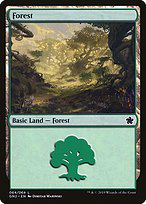

In [120]:
response = requests.get(images[0]['small'])
img = Image.open(BytesIO(response.content))
img